# 6th_homework

### Import Section

In [1]:
import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from src import utils
from src import recommenders
from src import metrics

from matplotlib import pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score

### Global Settings Section

In [2]:
random_state_global = 0

### Path Section

In [3]:
PATH_DATA = r'../2th lesson/retail_train.csv'
PATH_ITEM_FEATURES = r'../2th lesson/product.csv'
PATH_USER_FEATURES = r'../2th lesson/hh_demographic.csv'

## Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

#### Загрузка данных

In [4]:
# Загрузка данных.
data = pd.read_csv(PATH_DATA)
item_features = pd.read_csv(PATH_ITEM_FEATURES)
user_features = pd.read_csv(PATH_USER_FEATURES)

# Обработка названий столбцов.
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features = item_features.rename(columns={'product_id': 'item_id'})
user_features = user_features.rename(columns={'household_key': 'user_id'})

In [5]:
# Проверка.
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [6]:
# Проверка.
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [7]:
# Проверка.
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


#### Разбиение данных

In [8]:
# Разбиение данных.
data_train, data_test = utils.train_test_split(data, 'week_no', data['week_no'].max() - 9)
data_valid, data_test = utils.train_test_split(data_test, 'week_no', data_test['week_no'].max() - 3)

In [9]:
# Проверка: размер исходного набора данных.
data.shape

(2396804, 12)

In [10]:
# Проверка: размер обучающего набора данных.
data_train.shape

(2108779, 12)

In [11]:
# Удаление товаров, которых нет в обучающей выборке.
data_valid = data_valid[data_valid['user_id'].isin(data_train['user_id'])]
data_valid = data_valid[data_valid['item_id'].isin(data_train['item_id'])]

# Проверка: размер валидационного набора данных.
data_valid.shape

(165198, 12)

In [12]:
# Проверка: недели валидационного набора данных.
data_valid['week_no'].unique()

array([86, 87, 88, 89, 90, 91], dtype=int64)

In [13]:
# Удаление товаров, которых нет в обучающей выборке.
data_test = data_test[data_test['user_id'].isin(data_train['user_id'])]
data_test = data_test[data_test['item_id'].isin(data_train['item_id'])]

# Проверка: размер тестового набора данных.
data_test.shape

(114212, 12)

In [14]:
# Проверка: недели тестового набора данных.
data_test['week_no'].unique()

array([92, 93, 94, 95], dtype=int64)

#### Обработка данных

In [15]:
# Фильтрация товаров.
data_train = utils.prefilter_items(data_train, 'item_id', 'quantity')

# Проверка.
data_train.tail()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2109568,856,40630539494,593,999999,1,1.99,372,-1.0,1831,85,0.0,0.0
2109569,856,40630539494,593,1120213,1,1.67,372,0.0,1831,85,0.0,0.0
2109570,856,40630539494,593,999999,1,5.69,372,-0.3,1831,85,0.0,0.0
2109571,856,40630539494,593,999999,1,10.99,372,-3.3,1831,85,0.0,0.0
2109572,856,40630539494,593,999999,1,0.89,372,0.0,1831,85,0.0,0.0


#### Подготовка таблиц для результатов прогнозирования

In [16]:
# Подготовка тренировочной таблицы.
result_train = utils.prepare_result(data_train)

# Проверка.
result_train.head(2)

,user_id,actual
0,1,"[999999, 840361, 845307, 852014, 856942, 91267..."
1,2,"[854852, 930118, 1077555, 1098066, 999999, 556..."


In [17]:
# Подготовка валидационной таблицы.
result_valid = utils.prepare_result(data_valid)

# Проверка.
result_valid.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 875240, 87737..."
1,2,"[838136, 839656, 861272, 866211, 870791, 87391..."


In [18]:
# Подготовка тестовой таблицы.
result_test = utils.prepare_result(data_test)

# Проверка.
result_test.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


#### Применение модели первого уровня

In [19]:
# Инициализация модели первого уровня.
mr = recommenders.MainRecommender(random_state=random_state_global)

In [20]:
%%time

# Обучения модели первого уровня.
mr.fit(data_train)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

Wall time: 3.46 s


#### Модель первого уровня "model_als"

In [21]:
# Формирование таблицы метрик модели первого уровня.
df_metrics = pd.DataFrame(columns=['precision_train', 'precision_valid', 'precision_test',
                                   'recall_train', 'recall_valid', 'recall_test'])

In [22]:
%%time

# Прогнозирование при помощи модели AlternatingLeastSquares на тестовой выборке.
result_train['pred_als'] = result_train['user_id'].apply(lambda user_id: mr.predict_als(user_id, N=50))

# Проверка.
result_train.head(2)

Wall time: 7.21 s


,user_id,actual,pred_als
0,1,"[999999, 840361, 845307, 852014, 856942, 91267...","[981760, 1005186, 911878, 962568, 826249, 8623..."
1,2,"[854852, 930118, 1077555, 1098066, 999999, 556...","[981760, 1005186, 844165, 911878, 826249, 8623..."


In [23]:
# Вычисление метрик на тестовой выборке.
df_metrics.loc['model_als', 'precision_train'] = metrics.precision_at_k(result_train['actual'], result_train['pred_als'], K=50)
df_metrics.loc['model_als', 'recall_train'] = metrics.recall_at_k(result_train['actual'], result_train['pred_als'], K=50)

In [24]:
%%time

# Прогнозирование при помощи модели AlternatingLeastSquares на валидационной выборке.
result_valid['pred_als'] = result_valid['user_id'].apply(lambda user_id: mr.predict_als(user_id, N=50))

# Проверка.
result_valid.head(2)

Wall time: 5.98 s


,user_id,actual,pred_als
0,1,"[853529, 865456, 867607, 872137, 875240, 87737...","[981760, 1005186, 911878, 962568, 826249, 8623..."
1,2,"[838136, 839656, 861272, 866211, 870791, 87391...","[981760, 1005186, 844165, 911878, 826249, 8623..."


In [25]:
# Вычисление метрик на валидационной выборке.
df_metrics.loc['model_als', 'precision_valid'] = metrics.precision_at_k(result_valid['actual'], result_valid['pred_als'], K=50)
df_metrics.loc['model_als', 'recall_valid'] = metrics.recall_at_k(result_valid['actual'], result_valid['pred_als'], K=50)

#### Модель первого уровня "model_sur"

In [26]:
%%time

# Прогнозирование при помощи модели similar_users_recommendation на тестовой выборке.
result_train['pred_sur'] = result_train['user_id'].apply(lambda user_id: mr.predict_sur(user_id, N=50))

# Проверка.
result_train.head(2)

Wall time: 2.24 s


,user_id,actual,pred_als,pred_sur
0,1,"[999999, 840361, 845307, 852014, 856942, 91267...","[981760, 1005186, 911878, 962568, 826249, 8623...","[6534178, 6533889, 6534166, 6544236, 1404121, ..."
1,2,"[854852, 930118, 1077555, 1098066, 999999, 556...","[981760, 1005186, 844165, 911878, 826249, 8623...","[6534178, 6533889, 6534166, 6544236, 1404121, ..."


In [27]:
# Вычисление метрик на тестовой выборке.
df_metrics.loc['model_sur', 'precision_train'] = metrics.precision_at_k(result_train['actual'], result_train['pred_sur'], K=50)
df_metrics.loc['model_sur', 'recall_train'] = metrics.recall_at_k(result_train['actual'], result_train['pred_sur'], K=50)

In [28]:
%%time

# Прогнозирование при помощи модели similar_users_recommendation на валидационной выборке.
result_valid['pred_sur'] = result_valid['user_id'].apply(lambda user_id: mr.predict_sur(user_id, N=50))

# Проверка.
result_valid.head(2)

Wall time: 1.93 s


,user_id,actual,pred_als,pred_sur
0,1,"[853529, 865456, 867607, 872137, 875240, 87737...","[981760, 1005186, 911878, 962568, 826249, 8623...","[6534178, 6533889, 6534166, 6544236, 1404121, ..."
1,2,"[838136, 839656, 861272, 866211, 870791, 87391...","[981760, 1005186, 844165, 911878, 826249, 8623...","[6534178, 6533889, 6534166, 6544236, 1404121, ..."


In [29]:
# Вычисление метрик на валидационной выборке.
df_metrics.loc['model_sur', 'precision_valid'] = metrics.precision_at_k(result_valid['actual'], result_valid['pred_sur'], K=50)
df_metrics.loc['model_sur', 'recall_valid'] = metrics.recall_at_k(result_valid['actual'], result_valid['pred_sur'], K=50)

#### Анализ метрик

In [30]:
# Вывод метрик.
df_metrics

,precision_train,precision_valid,precision_test,recall_train,recall_valid,recall_test
model_als,0.409576,0.103749,NaN,0.103796,0.101098,NaN
model_sur,0.220993,0.054958,NaN,0.074026,0.059383,NaN


Наилучшую метрику "recall@k" на валидационной выборке демонстрирует модель AlternatingLeastSquares со следующими настройками:

     regularization=0.1,
     iterations=15,
     calculate_training_loss=True,
     use_gpu=False,
     random_state=random_state_global (0)

Также стоит заметить, что модель similar_users_recommendation не выдёт достаточное количество прогнозов, поэтому использует наиболее популярные товары.

#### Зависимость метрики "recall@k" от K

In [31]:
# Список для проверки различных количеств рекомендованных товаров K.
list_k = [20, 50, 100, 200, 500]

In [32]:
%%time

# Прогнозирование при помощи модели AlternatingLeastSquares на валидационной выборке.
result_valid['pred_als'] = result_valid['user_id'].apply(lambda user_id: mr.predict_als(user_id, N=500))

Wall time: 7.56 s


In [33]:
%%time

# Прогнозирование при помощи модели similar_users_recommendation на валидационной выборке.
result_valid['pred_sur'] = result_valid['user_id'].apply(lambda user_id: mr.predict_sur(user_id, N=500))

Wall time: 37 s


In [34]:
%%time

# Расчёт метрик.
df_metrics_recall = pd.DataFrame(columns=['K', 'pred_als', 'pred_sur'])

for i in range(len(list_k)):
    df_metrics_recall.loc[i, 'K'] = list_k[i]
    df_metrics_recall.loc[i, 'pred_als'] = metrics.recall_at_k(result_valid['actual'], result_valid['pred_als'], K=list_k[i])
    df_metrics_recall.loc[i, 'pred_sur'] = metrics.recall_at_k(result_valid['actual'], result_valid['pred_sur'], K=list_k[i])

df_metrics_recall

Wall time: 1.64 s


,K,pred_als,pred_sur
0,20,0.010975,0.017575
1,50,0.025824,0.059383
2,100,0.050234,0.1098
3,200,0.116758,0.158766
4,500,0.281016,0.241932


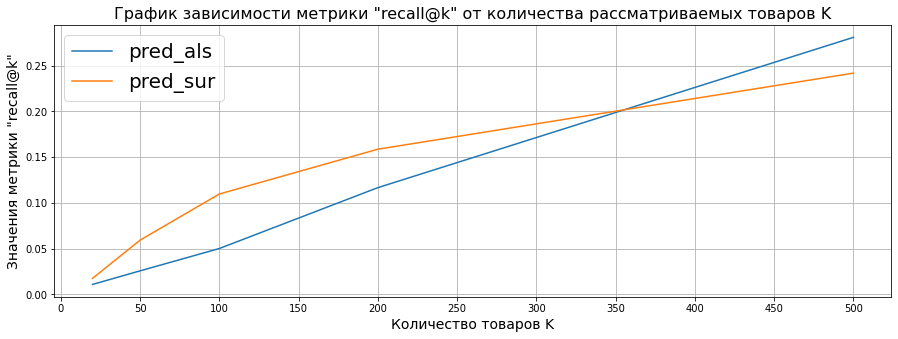

In [35]:
# Визуализация метрик.
df_metrics_recall.plot(x='K', y=['pred_als', 'pred_sur'], figsize=(15, 5), grid=True)

plt.legend(prop={'size': 20})
plt.xticks(np.arange(0, 550, 50))

plt.title('График зависимости метрики "recall@k" от количества рассматриваемых товаров K', fontsize=16)
plt.xlabel('Количество товаров K', fontsize=14)
plt.ylabel('Значения метрики "recall@k"', fontsize=14);

С ростом количества рекомендуемых товаров K значение метрики "recall@k" для обеих моделей увеличивается. Улучшение метрики может быть объяснено тем, что у моделей становится больше попыток для верных прогнозов: больше товаров - больше шанс угадать. В действительности пользователи редко рассматривают больше десяти рекомендаций, поэтому показания метрики следует учитывать около соответствующих значений.

Однако в случае с многоуровневой рекомендательной системой, первая модель для дальнейшего рассмотрения может выбирать значительно больше товаров. У моделей на следующих уровнях будет больше простора для уточнения рекомендаций.

## Задание 2

Обучите модель 2-ого уровня, при этом:
- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
- Вырос ли precision@5 при использовании двухуровневой модели?

#### Оценка метрики "precision@5" для одноуровневой модели

In [36]:
%%time

# Прогнозирование пяти товаров при помощи двух моделей AlternatingLeastSquares и similar_users_recommendation.
result_test['pred_als'] = result_test['user_id'].apply(lambda user_id: mr.predict_als(user_id, N=5))
result_test['pred_sur'] = result_test['user_id'].apply(lambda user_id: mr.predict_sur(user_id, N=5))

Wall time: 5.98 s


In [37]:
# Расчёт метрик.
df_metrics = pd.DataFrame(columns=['precision_lvl_1', 'precision_lvl_2'])

df_metrics.loc['model_als', 'precision_lvl_1'] = metrics.precision_at_k(result_test['actual'], result_test['pred_als'], K=5)
df_metrics.loc['model_sur', 'precision_lvl_1'] = metrics.precision_at_k(result_test['actual'], result_test['pred_sur'], K=5)

df_metrics

,precision_lvl_1,precision_lvl_2
model_als,0.145633,NaN
model_sur,0.046222,NaN


Модель AlternatingLeastSquares демонстрирует лучшую метрику качества "precision@5", поэтому далее двухуровневую модель будем строить на её основе.

### Подготовка данных для модели второго уровня - обучающая выборка

In [38]:
# Вывод результатов прогноза моделей первого уровня на валидационной выборке.
result_valid.head(2)

,user_id,actual,pred_als,pred_sur
0,1,"[853529, 865456, 867607, 872137, 875240, 87737...","[9705473, 1042438, 962568, 944137, 1075214, 10...","[6534178, 6533889, 6534166, 6544236, 1404121, ..."
1,2,"[838136, 839656, 861272, 866211, 870791, 87391...","[9705473, 1042438, 962568, 944137, 944139, 107...","[6534178, 6533889, 6534166, 6544236, 1404121, ..."


In [39]:
# Подготовка таблицы для обучения модели второго уровня.
X_train = utils.prepare_result_lvl_2(data=result_valid, feature_predicted='pred_als')

# Проверка.
X_train.head(7)

,user_id,item_id,pred_als,actual
0,1,9705473,1,0
1,1,1042438,1,0
2,1,962568,1,0
3,1,944137,1,0
4,1,944139,1,0
5,1,1075214,1,0
6,1,1005583,1,0


#### Добавление признаков пользователей

In [40]:
# Добавление признаков пользователей "age_desc" и "income_desc".
X_train = X_train.merge(user_features[['user_id', 'age_desc', 'income_desc']], on='user_id')

# Проверка.
X_train.head(2)

,user_id,item_id,pred_als,actual,age_desc,income_desc
0,1,9705473,1,0,65+,35-49K
1,1,1042438,1,0,65+,35-49K


#### Добавление признаков товаров

In [41]:
# Добавление признаков товаров "manufacturer" и "department".
X_train = X_train.merge(item_features[['item_id', 'manufacturer', 'department']], on='item_id')

# Проверка.
X_train.head(2)

,user_id,item_id,pred_als,actual,age_desc,income_desc,manufacturer,department
0,1,9705473,1,0,65+,35-49K,661,PRODUCE
1,16,9705473,1,0,45-54,50-74K,661,PRODUCE


#### Добавление признаков пары пользователь-товар

In [42]:
%%time

# Формирование таблицы признаков пользователь-товар.
user_item_features = data_train.copy()

user_item_features['user_item_id'] = (
    user_item_features['user_id']
    .astype(str)
    .str
    .cat(user_item_features['item_id'].astype(str), sep='_')
)

user_item_features = (
    user_item_features
    .groupby(by='user_item_id')[['quantity', 'sales_value']]
    .sum()
    .reset_index()
)

user_item_features.head(2)

Wall time: 2.96 s


,user_item_id,quantity,sales_value
0,1000_1001827,1,1.69
1,1000_1003188,28,40.00


In [43]:
# Формирование идентификатора пользователь-товар.
X_train['user_item_id'] = (
    X_train['user_id']
    .astype(str)
    .str
    .cat(X_train['item_id'].astype(str), sep='_')
)

X_train.head(2)

,user_id,item_id,pred_als,actual,age_desc,income_desc,manufacturer,department,user_item_id
0,1,9705473,1,0,65+,35-49K,661,PRODUCE,1_9705473
1,16,9705473,1,0,45-54,50-74K,661,PRODUCE,16_9705473


In [44]:
# Добавление признаков пользователь-товар "quantity" и "sales_value".
X_train = X_train.merge(user_item_features, on='user_item_id')
X_train = X_train.drop(columns=['user_item_id'])

# Проверка.
X_train.head(2)

,user_id,item_id,pred_als,actual,age_desc,income_desc,manufacturer,department,quantity,sales_value
0,127,9705473,1,0,45-54,25-34K,661,PRODUCE,3,2.07
1,294,9705473,1,1,25-34,50-74K,661,PRODUCE,23,15.87


In [45]:
# Проверка структуры сформированной таблицы.
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65593 entries, 0 to 65592
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       65593 non-null  int64  
 1   item_id       65593 non-null  int64  
 2   pred_als      65593 non-null  int64  
 3   actual        65593 non-null  int32  
 4   age_desc      65593 non-null  object 
 5   income_desc   65593 non-null  object 
 6   manufacturer  65593 non-null  int64  
 7   department    65593 non-null  object 
 8   quantity      65593 non-null  int64  
 9   sales_value   65593 non-null  float64
dtypes: float64(1), int32(1), int64(5), object(3)
memory usage: 5.3+ MB


### Подготовка данных для модели второго уровня - тестовая выборка

In [46]:
# Вывод результатов прогноза моделей первого уровня на тестовой выборке.
result_test.head(2)

,user_id,actual,pred_als,pred_sur
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[981760, 1082185, 995242, 1029743, 1127831]","[6534178, 6533889, 6534166, 6544236, 1404121]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1085604, 844165, 951590, 962229, 8090521]","[6533889, 6534178, 6534166, 6544236, 1404121]"


In [47]:
# Подготовка таблицы для проверки модели второго уровня.
X_test = utils.prepare_result_lvl_2(data=result_test, feature_predicted='pred_als')

# Проверка.
X_test.head(7)

,user_id,item_id,pred_als,actual
0,1,1085604,1,0
1,1,844165,1,0
2,1,951590,1,0
3,1,962229,1,0
4,1,8090521,1,0
5,3,981760,1,0
6,3,1082185,1,0


#### Добавление признаков пользователей

In [48]:
# Добавление признаков пользователей "age_desc" и "income_desc".
X_test = X_test.merge(user_features[['user_id', 'age_desc', 'income_desc']], on='user_id')

# Проверка.
X_test.head(2)

,user_id,item_id,pred_als,actual,age_desc,income_desc
0,1,1085604,1,0,65+,35-49K
1,1,844165,1,0,65+,35-49K


#### Добавление признаков товаров

In [49]:
# Добавление признаков товаров "manufacturer" и "department".
X_test = X_test.merge(item_features[['item_id', 'manufacturer', 'department']], on='item_id')

# Проверка.
X_test.head(2)

,user_id,item_id,pred_als,actual,age_desc,income_desc,manufacturer,department
0,1,1085604,1,0,65+,35-49K,103,GROCERY
1,300,1085604,1,0,55-64,Under 15K,103,GROCERY


#### Добавление признаков пары пользователь-товар

In [50]:
# Формирование идентификатора пользователь-товар.
X_test['user_item_id'] = (
    X_test['user_id']
    .astype(str)
    .str
    .cat(X_test['item_id'].astype(str), sep='_')
)

# Проверка.
X_test.head(2)

,user_id,item_id,pred_als,actual,age_desc,income_desc,manufacturer,department,user_item_id
0,1,1085604,1,0,65+,35-49K,103,GROCERY,1_1085604
1,300,1085604,1,0,55-64,Under 15K,103,GROCERY,300_1085604


In [51]:
# Добавление признаков пользователь-товар "quantity" и "sales_value".
X_test = X_test.merge(user_item_features, on='user_item_id')
X_test = X_test.drop(columns=['user_item_id'])

# Проверка.
X_test.head(2)

,user_id,item_id,pred_als,actual,age_desc,income_desc,manufacturer,department,quantity,sales_value
0,334,1085604,1,0,45-54,Under 15K,103,GROCERY,1,1.00
1,864,1085604,1,0,35-44,15-24K,103,GROCERY,2,2.29


In [52]:
# Проверка структуры сформированной таблицы.
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1396 entries, 0 to 1395
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       1396 non-null   int64  
 1   item_id       1396 non-null   int64  
 2   pred_als      1396 non-null   int64  
 3   actual        1396 non-null   int32  
 4   age_desc      1396 non-null   object 
 5   income_desc   1396 non-null   object 
 6   manufacturer  1396 non-null   int64  
 7   department    1396 non-null   object 
 8   quantity      1396 non-null   int64  
 9   sales_value   1396 non-null   float64
dtypes: float64(1), int32(1), int64(5), object(3)
memory usage: 114.5+ KB


### Построение модели второго уровня

#### Обучение модели

In [53]:
# %%time

# cat_feats = ['age_desc', 'income_desc', 'department']
# feature_name = ['user_id', 'item_id', 'age_desc', 'income_desc', 'manufacturer', 'department', 'quantity', 'sales_value']

# lgb = LGBMClassifier(objective='binary', max_depth=7, feature_name=feature_name, categorical_column=cat_feats)
# lgb.fit(X=X_train.drop(columns=['pred_als', 'actual']),
#         y=X_train['actual'])

Модель LGBMClassifier выдавала ошибку при работе с категориальными переменными, поэтому была использована модель CatBoostClassifier.

In [54]:
%%time

cat_feats = ['age_desc', 'income_desc', 'department']

cbc = CatBoostClassifier(silent=True, task_type='GPU', cat_features=cat_feats, random_state=random_state_global)

cbc.fit(X=X_train.drop(columns=['pred_als', 'actual']),
        y=X_train['actual'])

Wall time: 18.1 s


#### Прогнозирование

In [55]:
# Прогнозирование моделью второго уровна на обучающей выборке.
X_train['pred_cbc'] = cbc.predict(X_train.drop(columns=['pred_als', 'actual']))

# Проверка.
X_train.head(2)

,user_id,item_id,pred_als,actual,age_desc,income_desc,manufacturer,department,quantity,sales_value,pred_cbc
0,127,9705473,1,0,45-54,25-34K,661,PRODUCE,3,2.07,0
1,294,9705473,1,1,25-34,50-74K,661,PRODUCE,23,15.87,1


In [56]:
# Прогнозирование моделью второго уровна на тестовой выборке.
X_test['pred_cbc'] = cbc.predict(X_test.drop(columns=['pred_als', 'actual']))

# Проверка.
X_test.head(2)

,user_id,item_id,pred_als,actual,age_desc,income_desc,manufacturer,department,quantity,sales_value,pred_cbc
0,334,1085604,1,0,45-54,Under 15K,103,GROCERY,1,1.00,0
1,864,1085604,1,0,35-44,15-24K,103,GROCERY,2,2.29,0


#### Сравнение метрик моделей первого и второго уровней

In [57]:
# Вывод метрики модели первого уровня на валидационной выборке.
precision_score(X_train['actual'], X_train['pred_als'])

0.14411598798652295

In [58]:
# Вывод метрик модели второго уровня на обучающей выборке.
print(classification_report(X_train['actual'], X_train['pred_cbc']))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     56140
           1       0.76      0.23      0.36      9453

    accuracy                           0.88     65593
   macro avg       0.82      0.61      0.64     65593
weighted avg       0.87      0.88      0.85     65593



In [59]:
# Вывод метрик модели второго уровня на тестовой выборке.
print(classification_report(X_test['actual'], X_test['pred_cbc']))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       937
           1       0.67      0.63      0.65       459

    accuracy                           0.77      1396
   macro avg       0.74      0.74      0.74      1396
weighted avg       0.77      0.77      0.77      1396



Модель второго уровня демонстрируют значительно лучшую метрику "precision".

## Задание 3

#### Формирование результатов прогноза двухуровневой модели

In [60]:
# Формирование результатов прогноза двухуровневой модели.
result_test = result_test.merge(X_test[X_test['pred_cbc'] == 1]
                                .groupby(by='user_id')['item_id']
                                .agg(list)
                                .reset_index()
                                .rename(columns={'item_id': 'pred_cbc'}),
                                on='user_id')

# Проверка.
result_test.head(2)

,user_id,actual,pred_als,pred_sur,pred_cbc
0,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[981760, 1082185, 995242, 1029743, 1133018]","[6534178, 6533889, 6534166, 6544236, 1404121]",[1082185]
1,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[6534178, 397896, 1082185, 6534166, 1404121]","[6533889, 6534166, 6534178, 6544236, 1404121]",[1082185]


#### Оценка метрики "precision@5" двухуровневой модели

In [61]:
# Вычисление метрики "precision@5" двухуровневой модели.
df_metrics.loc['model_als', 'precision_lvl_2'] = metrics.precision_at_k(result_test['actual'], result_test['pred_cbc'], K=5)

# Вывод метрик.
df_metrics

,precision_lvl_1,precision_lvl_2
model_als,0.145633,0.655574
model_sur,0.046222,NaN


Построение двухуровневой модели на базе модели AlternatingLeastSquares позволило значительно улучшить метрику "precision@5".